# FastText Experimenty

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '../Data/wiki-news-300d-1M.vec.zip'

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, LSTM, GRU


In [ ]:
dataset = pd.read_csv('..Data/final_2000_balanced.csv')

## Split datasetu

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One-hot encoder

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
y_test.shape

(365, 44)

## Embdding matica

In [ ]:
embeddings_index = {}
with open('wiki-news-300d-1M.vec') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 999995 word vectors.


In [ ]:
embedding_dim = 300
vocab_size = 40000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(X_train.values)

In [ ]:
voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 34194 words (5806 misses)


# Modely

## DNN model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.GlobalAveragePooling1D()(emb)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
output_layer =  keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 6000, 300)         12000600  
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1024)              308224

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 10

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/10
42/42 [==============================] - 91s 2s/step - loss: 3.7654 - accuracy: 0.0236 - val_loss: 3.7217 - val_accuracy: 0.0479
Epoch 2/10
42/42 [==============================] - 86s 2s/step - loss: 3.6616 - accuracy: 0.0601 - val_loss: 3.5488 - val_accuracy: 0.1096
Epoch 3/10
42/42 [==============================] - 84s 2s/step - loss: 3.3475 - accuracy: 0.1081 - val_loss: 3.1050 - val_accuracy: 0.1438
Epoch 4/10
42/42 [==============================] - 83s 2s/step - loss: 2.9250 - accuracy: 0.2002 - val_loss: 2.7777 - val_accuracy: 0.1849
Epoch 5/10
42/42 [==============================] - 85s 2s/step - loss: 2.6178 - accuracy: 0.2679 - val_loss: 2.4691 - val_accuracy: 0.3288
Epoch 6/10
42/42 [==============================] - 83s 2s/step - loss: 2.4043 - accuracy: 0.3257 - val_loss: 2.2317 - val_accuracy: 0.3562
Epoch 7/10
42/42 [==============================] - 83s 2s/step - loss: 2.1682 - accuracy: 0.3645 - val_loss: 2.1447 - val_accuracy: 0.3767
Epoch 8/10
42/42 [==

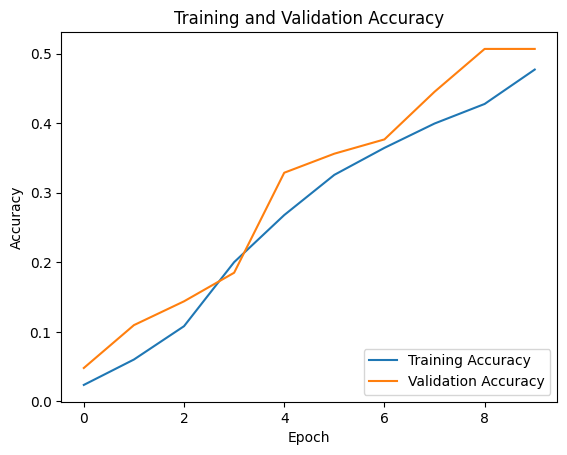

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

12/12 [==============================] - 0s 32ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.473972602739726
F1 Score: 0.44247283436747026
Precision: 0.5371223502194319
Recall: 0.473972602739726


## CNN Model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(emb)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 6000, 300)         12000600  
                                                                 
 conv1d_1 (Conv1D)           (None, 5997, 512)         614912    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2998, 512)         0         
 g1D)                                                            
                                                                 
 global_average_pooling1d_2  (None, 512)               0   

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 32, callbacks=[model_checkpoint_callback])

Epoch 1/10
42/42 [==============================] - 92s 2s/step - loss: 3.7531 - accuracy: 0.0335 - val_loss: 3.6767 - val_accuracy: 0.0479
Epoch 2/10
42/42 [==============================] - 89s 2s/step - loss: 3.6232 - accuracy: 0.0540 - val_loss: 3.4760 - val_accuracy: 0.1849
Epoch 3/10
42/42 [==============================] - 89s 2s/step - loss: 3.3285 - accuracy: 0.1309 - val_loss: 3.0993 - val_accuracy: 0.2055
Epoch 4/10
42/42 [==============================] - 90s 2s/step - loss: 2.9619 - accuracy: 0.2139 - val_loss: 2.7245 - val_accuracy: 0.2466
Epoch 5/10
42/42 [==============================] - 90s 2s/step - loss: 2.7184 - accuracy: 0.2451 - val_loss: 2.4551 - val_accuracy: 0.2671
Epoch 6/10
42/42 [==============================] - 89s 2s/step - loss: 2.3967 - accuracy: 0.2998 - val_loss: 2.2081 - val_accuracy: 0.3904
Epoch 7/10
42/42 [==============================] - 90s 2s/step - loss: 2.2395 - accuracy: 0.3470 - val_loss: 2.0344 - val_accuracy: 0.4247
Epoch 8/10
42/42 [==

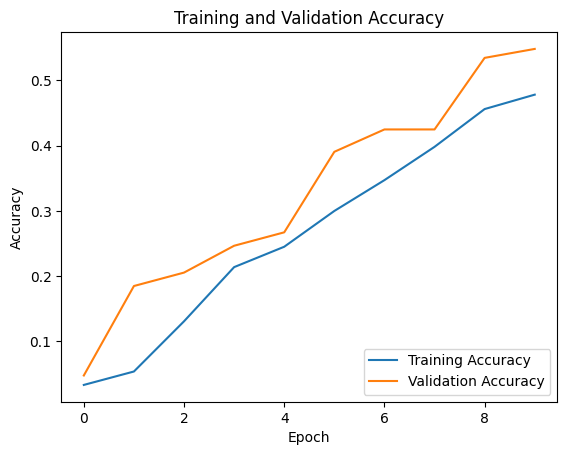

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

12/12 [==============================] - 1s 88ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.5452054794520548
F1 Score: 0.5238020557011296
Precision: 0.6101768450448789
Recall: 0.5452054794520548


## Biderectional LSTMU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(emb)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_5 (Embedding)     (None, 6000, 300)         12000600  
                                                                 
 bidirectional_1 (Bidirecti  (None, 6000, 256)         439296    
 onal)                                                           
                                                                 
 global_average_pooling1d_4  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback, stop], epochs=10, batch_size=128)

Epoch 1/10
11/11 [==============================] - 100s 9s/step - loss: 3.7781 - accuracy: 0.0289 - val_loss: 3.7605 - val_accuracy: 0.0205
Epoch 2/10
11/11 [==============================] - 97s 10s/step - loss: 3.7437 - accuracy: 0.0396 - val_loss: 3.7190 - val_accuracy: 0.0479
Epoch 3/10
11/11 [==============================] - 95s 9s/step - loss: 3.6691 - accuracy: 0.0594 - val_loss: 3.6096 - val_accuracy: 0.0753
Epoch 4/10
11/11 [==============================] - 95s 9s/step - loss: 3.5155 - accuracy: 0.0883 - val_loss: 3.4164 - val_accuracy: 0.0959
Epoch 5/10
11/11 [==============================] - 95s 9s/step - loss: 3.3346 - accuracy: 0.1104 - val_loss: 3.2139 - val_accuracy: 0.1301
Epoch 6/10
11/11 [==============================] - 95s 9s/step - loss: 3.1959 - accuracy: 0.1157 - val_loss: 3.0673 - val_accuracy: 0.1849
Epoch 7/10
11/11 [==============================] - 95s 9s/step - loss: 3.0233 - accuracy: 0.1446 - val_loss: 2.9600 - val_accuracy: 0.1438
Epoch 8/10
11/11 [

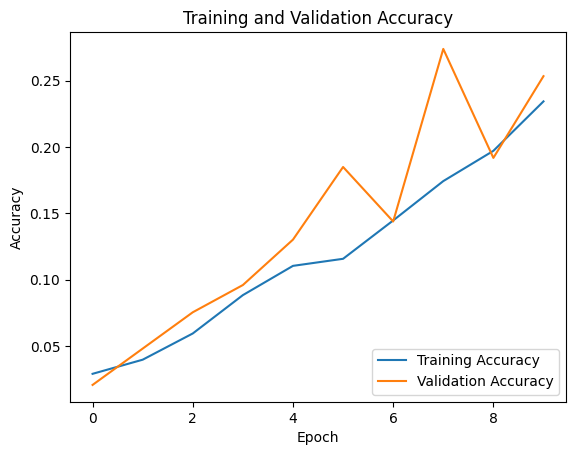

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

12/12 [==============================] - 3s 197ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.28493150684931506
F1 Score: 0.21313315187449894
Precision: 0.22077320201385225
Recall: 0.28493150684931506


## LSTM + GRU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.LSTM(256, return_sequences=True)(emb)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.GRU(128, return_sequences=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)


model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_6 (Embedding)     (None, 6000, 300)         12000600  
                                                                 
 lstm_3 (LSTM)               (None, 6000, 256)         570368    
                                                                 
 dropout_9 (Dropout)         (None, 6000, 256)         0         
                                                                 
 gru_1 (GRU)                 (None, 128)               148224    
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback, stop], epochs=10, batch_size=128)

Epoch 1/10
11/11 [==============================] - 103s 10s/step - loss: 3.7798 - accuracy: 0.0183 - val_loss: 3.7880 - val_accuracy: 0.0274
Epoch 2/10
11/11 [==============================] - 98s 10s/step - loss: 3.7595 - accuracy: 0.0403 - val_loss: 3.7779 - val_accuracy: 0.0342
Epoch 3/10
11/11 [==============================] - 17s 2s/step - loss: 3.7286 - accuracy: 0.0548 - val_loss: 3.8626 - val_accuracy: 0.0342
Epoch 4/10
11/11 [==============================] - 99s 10s/step - loss: 3.7006 - accuracy: 0.0578 - val_loss: 3.7586 - val_accuracy: 0.0342
Epoch 5/10
11/11 [==============================] - 97s 10s/step - loss: 3.6717 - accuracy: 0.0502 - val_loss: 3.7165 - val_accuracy: 0.0411
Epoch 6/10
11/11 [==============================] - 17s 2s/step - loss: 3.6261 - accuracy: 0.0685 - val_loss: 3.7197 - val_accuracy: 0.0548
Epoch 7/10
11/11 [==============================] - 99s 10s/step - loss: 3.5820 - accuracy: 0.0654 - val_loss: 3.6883 - val_accuracy: 0.0342
Epoch 8/10
11/

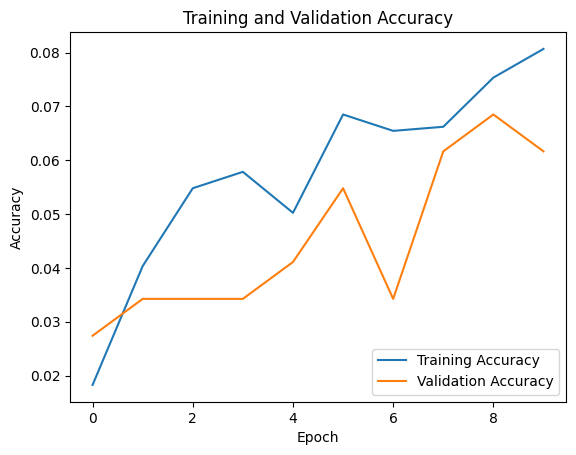

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

12/12 [==============================] - 4s 255ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.052054794520547946
F1 Score: 0.013928725439564648
Precision: 0.013519972558963598
Recall: 0.052054794520547946
